In [ ]:
from timeit import default_timer as timer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
import pickle
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sc
import sklearn as skl
from string import punctuation, whitespace
import re
import sys  
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/5sem/mmp/prac_report/3/realization
sys.path.insert(0, '/content/drive/MyDrive/5sem/mmp/prac_report/3/realization')
import ensembles
from copy import deepcopy
from sklearn.metrics import accuracy_score
%load_ext autoreload
from scipy.sparse import csr_matrix, hstack
sns.set_context("talk")
sns.set_style('darkgrid')


%autoreload 2
path = '/content/drive/MyDrive/5sem/mmp/prac_report/3/experiments/data/'

In [113]:
dt = pd.read_csv(path + 'train_data.csv')
y = pd.read_csv(path + 'train_target.csv')
dt.drop(columns=['index', 'id', 'date'], inplace=True)
y.drop(columns=['index'], inplace=True)
dt = dt.values
y = y['price'].values

In [114]:
X_train, X_test, y_train, y_test = train_test_split(dt, y, random_state=0, test_size=0.3)

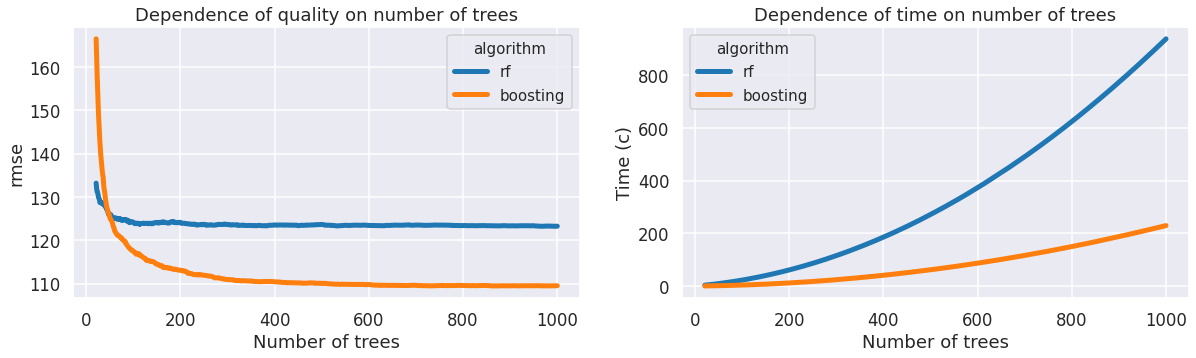

In [115]:
lab_v = []
pic_path = '/content/drive/MyDrive/5sem/mmp/prac_report/3/experiments/images/'
title_leg_size = '15'
font_leg_size = '15'
algs = {
    'rf': ensembles.RandomForestMSE(1000),
    'boosting': ensembles.GradientBoostingMSE(1000)
}

h = []
for name, reg in algs.items():
    history = reg.fit(X_train, y_train, X_test, y_test)
    h.append(history)
    lab_v.append(name)

n = 20
fig, axs = plt.subplots(figsize=(2 * 10, 5), ncols=2, nrows=1)
p = []
ticks = list(range(1, len(history['scores']) + 1))
for history in h:
    p.append(axs[0].plot(ticks[n:], history['scores'][n:], linewidth=5))

axs[0].set_title('Dependence of quality on number of trees')
axs[0].set_ylabel('rmse')
axs[0].set_xlabel('Number of trees')
axs[0].grid(True)

legend = axs[0].legend((pj[0] for pj in p), lab_v)
legend.set_title('algorithm')
plt.setp(axs[0].get_legend().get_texts(), fontsize=font_leg_size)
plt.setp(axs[0].get_legend().get_title(), fontsize=title_leg_size)


p = []
for history in h:
    p.append(axs[1].plot(ticks[n:], history['time'][n:], linewidth=5))

axs[1].set_title('Dependence of time on number of trees')
axs[1].set_ylabel('Time (c)')
axs[1].set_xlabel('Number of trees')
axs[1].grid(True)

legend = axs[1].legend((pj[0] for pj in p), lab_v)
legend.set_title('algorithm')
plt.setp(axs[1].get_legend().get_texts(), fontsize=font_leg_size)
plt.setp(axs[1].get_legend().get_title(), fontsize=title_leg_size)
fig.savefig(pic_path + 'n_estimators.pdf', bbox_inches='tight')
plt.show()

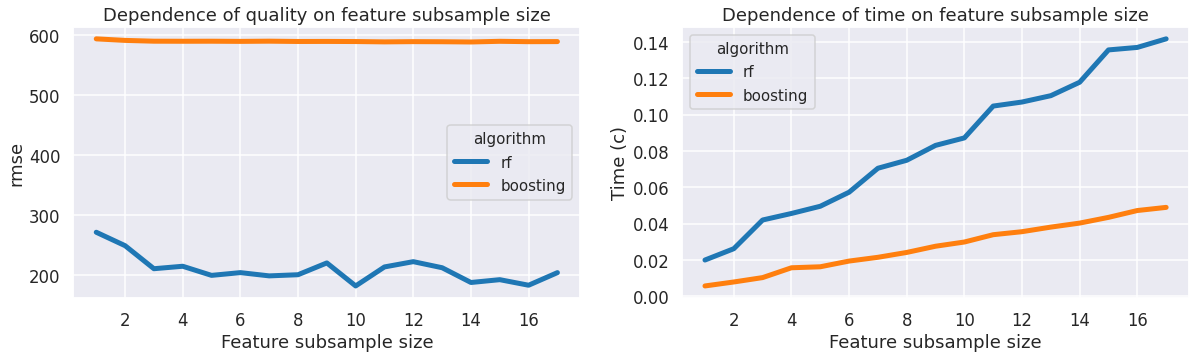

In [116]:
lab_v = []
algs = {
    'rf': ensembles.RandomForestMSE,
    'boosting': ensembles.GradientBoostingMSE
}
params = {
    'max_features': list(range(1, X_train.shape[1] + 1)),
    'max_depth': list(range(1, 16)) + [None],
    'lr': list(np.logspace(-4, 0, 29)) + [1.5] 
}

h = []
for name, mreg in algs.items():
    history = dict([('scores', []), ('time', [])])
    for max_f in params['max_features']:
        cmreg = deepcopy(mreg)
        reg = cmreg(n_estimators=1, feature_subsample_size = max_f)
        start = timer()
        reg.fit(X_train, y_train)
        end = timer()
        delta = end - start
        score = ensembles.rmse(y_test, reg.predict(X_test))
        history['scores'].append(score)
        history['time'].append(delta)
    lab_v.append(name)
    h.append(history)

fig, axs = plt.subplots(figsize=(2 * 10, 5), ncols=2, nrows=1)
p = []
ticks = list(range(1, len(history['scores']) + 1))
for history in h:
    p.append(axs[0].plot(ticks, history['scores'], linewidth=5))

axs[0].set_title('Dependence of quality on feature subsample size')
axs[0].set_ylabel('rmse')
axs[0].set_xlabel('Feature subsample size')
axs[0].grid(True)

legend = axs[0].legend((pj[0] for pj in p), lab_v)
legend.set_title('algorithm')
plt.setp(axs[0].get_legend().get_texts(), fontsize=font_leg_size)
plt.setp(axs[0].get_legend().get_title(), fontsize=title_leg_size)


p = []
for history in h:
    p.append(axs[1].plot(ticks, history['time'], linewidth=5))

axs[1].set_title('Dependence of time on feature subsample size')
axs[1].set_ylabel('Time (c)')
axs[1].set_xlabel('Feature subsample size')
axs[1].grid(True)

legend = axs[1].legend((pj[0] for pj in p), lab_v)
legend.set_title('algorithm')
plt.setp(axs[1].get_legend().get_texts(), fontsize=font_leg_size)
plt.setp(axs[1].get_legend().get_title(), fontsize=title_leg_size)
fig.savefig(pic_path + 'feature_subsample_size.pdf', bbox_inches='tight')
plt.show()

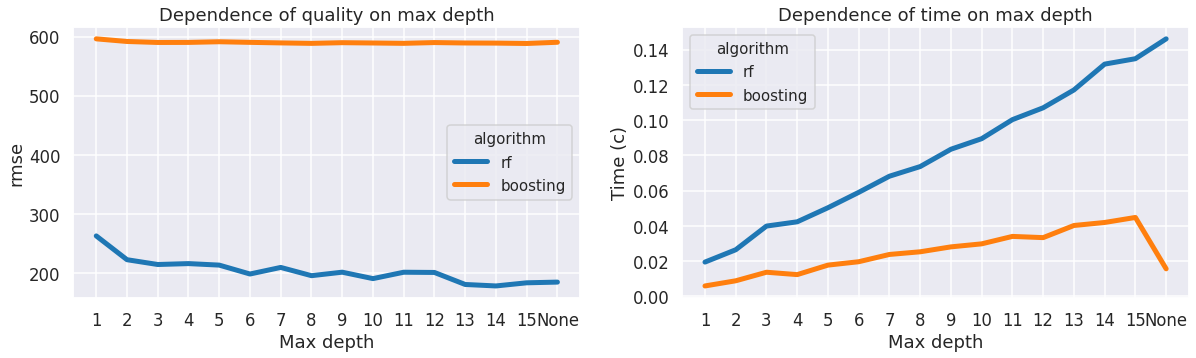

In [117]:
h = []
lab_v = []
for name, mreg in algs.items():
    history = dict([('scores', []), ('time', [])])
    for max_f in params['max_depth']:
        cmreg = deepcopy(mreg)
        reg = cmreg(n_estimators=1, feature_subsample_size = max_f)
        start = timer()
        reg.fit(X_train, y_train)
        end = timer()
        delta = end - start
        score = ensembles.rmse(y_test, reg.predict(X_test))
        history['scores'].append(score)
        history['time'].append(delta)
    h.append(history)
    lab_v.append(name)

fig, axs = plt.subplots(figsize=(2 * 10, 5), ncols=2, nrows=1)
p = []
labels = [str(i) for i in range(1, len(history['scores']))] + ['None']
ticks = list(range(1, len(history['scores']) + 1))
for history in h:
    p.append(axs[0].plot(ticks, history['scores'], linewidth=5))

axs[0].set_title('Dependence of quality on max depth')
axs[0].set_ylabel('rmse')
axs[0].set_xlabel('Max depth')
axs[0].grid(True)
plt.sca(axs[0])
plt.xticks(ticks, labels)

legend = axs[0].legend((pj[0] for pj in p), lab_v)
legend.set_title('algorithm')
plt.setp(axs[0].get_legend().get_texts(), fontsize=font_leg_size)
plt.setp(axs[0].get_legend().get_title(), fontsize=title_leg_size)


p = []
for history in h:
    p.append(axs[1].plot(ticks, history['time'], linewidth=5))

axs[1].set_title('Dependence of time on max depth')
axs[1].set_ylabel('Time (c)')
axs[1].set_xlabel('Max depth')
axs[1].grid(True)
plt.sca(axs[1])
plt.xticks(ticks, labels)

legend = axs[1].legend((pj[0] for pj in p), lab_v)
legend.set_title('algorithm')
plt.setp(axs[1].get_legend().get_texts(), fontsize=font_leg_size)
plt.setp(axs[1].get_legend().get_title(), fontsize=title_leg_size)
fig.savefig(pic_path + 'max_depth.pdf', bbox_inches='tight')
plt.show()

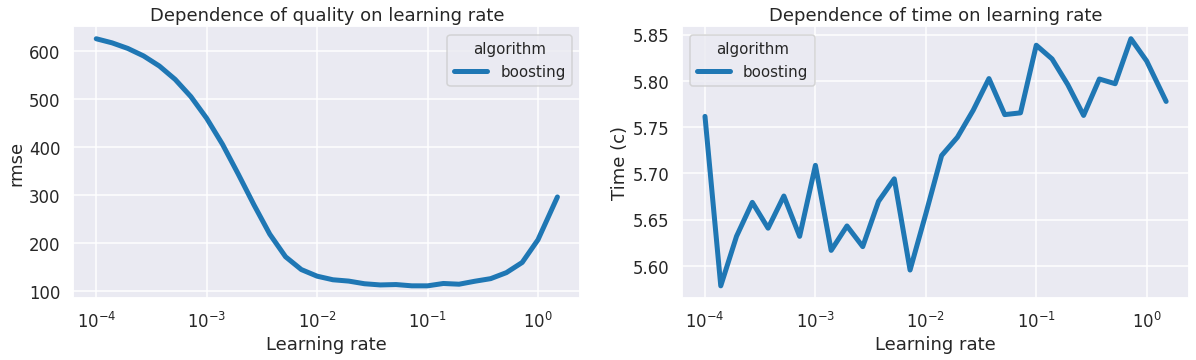

In [125]:
h = []
lab_v = []
name = 'boosting'
mreg = algs['boosting']
history = dict([('scores', []), ('time', [])])
for lr in params['lr']:
    cmreg = deepcopy(mreg)
    reg = cmreg(n_estimators=400, learning_rate=lr)
    start = timer()
    reg.fit(X_train, y_train)
    end = timer()
    delta = end - start
    score = ensembles.rmse(y_test, reg.predict(X_test))
    history['scores'].append(score)
    history['time'].append(delta)
h.append(history)
lab_v.append(name)

fig, axs = plt.subplots(figsize=(2 * 10, 5), ncols=2, nrows=1)
p = []
for history in h:
    p.append(axs[0].plot(params['lr'], history['scores'], linewidth=5))

axs[0].set_title('Dependence of quality on learning rate')
axs[0].set_ylabel('rmse')
axs[0].set_xlabel('Learning rate')
axs[0].grid(True)
plt.sca(axs[0])
plt.xscale('log')

legend = axs[0].legend((pj[0] for pj in p), lab_v)
legend.set_title('algorithm')
plt.setp(axs[0].get_legend().get_texts(), fontsize=font_leg_size)
plt.setp(axs[0].get_legend().get_title(), fontsize=title_leg_size)


p = []
for history in h:
    p.append(axs[1].plot(params['lr'], history['time'], linewidth=5))

axs[1].set_title('Dependence of time on learning rate')
axs[1].set_ylabel('Time (c)')
axs[1].set_xlabel('Learning rate')
axs[1].grid(True)
plt.sca(axs[1])
plt.xscale('log')

legend = axs[1].legend((pj[0] for pj in p), lab_v)
legend.set_title('algorithm')
plt.setp(axs[1].get_legend().get_texts(), fontsize=font_leg_size)
plt.setp(axs[1].get_legend().get_title(), fontsize=title_leg_size)
fig.savefig(pic_path + 'learning_rate.pdf', bbox_inches='tight')
plt.show()

In [127]:
type({})

dict